In [61]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np
import pathlib
import shutil
import tempfile

In [62]:
!pip install git+https://github.com/tensorflow/docs

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [63]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [64]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np
import pathlib
import shutil
import tempfile

In [65]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [66]:
# new import
import pandas as pd
import numpy as np

np.set_printoptions(precision=3,suppress=True)

import tensorflow as tf
from tensorflow.keras import layers



In [67]:
point_df = pd.read_csv('rank_d_r.csv')
point_df.head()

,Unnamed: 0,Group,Point,m_distance,rank,measures
0,0,ST001,R115,5556.896692,42.5,2.0
1,2,ST001,R110,9378.673333,46.0,2.0
2,3,ST001,R108,9304.765367,51.0,2.0
3,4,ST001,R001,2525.659184,37.0,2.0
4,5,ST001,R002,2744.286374,41.5,2.0


In [68]:
df_ml = point_df.loc[:, ('m_distance', 'rank')].copy()
df_ml

,m_distance,rank
0,5556.896692,42.5
1,9378.673333,46.0
2,9304.765367,51.0
3,2525.659184,37.0
4,2744.286374,41.5
...,...,...
2306,10746.169193,17.0
2307,8261.796827,25.5
2308,2796.195983,38.5
2309,2922.616380,39.0


In [69]:
FEATURES = 2

In [71]:
df = tf.keras.utils.get_file("rank_d_r.csv", )

ValueError: Please specify the "origin" argument (URL of the file to download).

In [70]:
ds = tf.data.experimental.CsvDataset(df,[float(),]*(FEATURES+1))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [46]:
point_features = df_ml.copy()
point_labels = df_ml.pop('rank')

In [47]:
point_features = np.array(point_features)
point_features

array([[5556.897,   42.5  ],
       [9378.673,   46.   ],
       [9304.765,   51.   ],
       ...,
       [2796.196,   38.5  ],
       [2922.616,   39.   ],
       [1879.174,   23.   ]])

In [48]:
point_model = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1)
])

point_model.compile(loss = tf.keras.losses.MeanSquaredError(),
                      optimizer = tf.keras.optimizers.Adam())


In [49]:
point_model.fit(point_features,point_labels, epochs=10)

Epoch 1/10
73/73 [==============================] - 1s 1ms/step - loss: 1629396.3750
Epoch 2/10
73/73 [==============================] - 0s 1ms/step - loss: 1208.6207
Epoch 3/10
73/73 [==============================] - 0s 1ms/step - loss: 604.1618
Epoch 4/10
73/73 [==============================] - 0s 1ms/step - loss: 567.4350
Epoch 5/10
73/73 [==============================] - 0s 1ms/step - loss: 538.9619
Epoch 6/10
73/73 [==============================] - 0s 1ms/step - loss: 491.8824
Epoch 7/10
73/73 [==============================] - 0s 1ms/step - loss: 449.5515
Epoch 8/10
73/73 [==============================] - 0s 1ms/step - loss: 409.5100
Epoch 9/10
73/73 [==============================] - 0s 1ms/step - loss: 367.0008
Epoch 10/10
73/73 [==============================] - 0s 1ms/step - loss: 328.6708


In [50]:
normalize = layers.Normalization()

In [51]:
normalize.adapt(point_features)

In [60]:
norm_point_model = tf.keras.Sequential([
    normalize,
    layers.Dense(64),
    layers.Dense(1)
])

norm_point_model.compile(loss = tf.keras.losses.MeanSquaredError(),
                           optimizer = tf.keras.optimizers.Adam())

norm_point_model.fit(point_features, point_labels, epochs=10)

norm_point_model

Epoch 1/10
73/73 [==============================] - 1s 2ms/step - loss: 2252.0027
Epoch 2/10
73/73 [==============================] - 0s 1ms/step - loss: 2087.7766
Epoch 3/10
73/73 [==============================] - 0s 1ms/step - loss: 1823.8081
Epoch 4/10
73/73 [==============================] - 0s 1ms/step - loss: 1458.9026
Epoch 5/10
73/73 [==============================] - 0s 1ms/step - loss: 1030.4106
Epoch 6/10
73/73 [==============================] - 0s 1ms/step - loss: 633.0504
Epoch 7/10
73/73 [==============================] - 0s 1ms/step - loss: 326.6917
Epoch 8/10
73/73 [==============================] - 0s 1ms/step - loss: 142.3825
Epoch 9/10
73/73 [==============================] - 0s 1ms/step - loss: 53.0772
Epoch 10/10
73/73 [==============================] - 0s 1ms/step - loss: 17.3531


In [53]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE


In [54]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)


In [55]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name)
    ]

In [56]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [57]:
size_histories = {}

In [58]:
size_histories['norm'] = compile_and_fit(norm_point_model, 'sizes/Norm')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 2)                 5         
 tion)                                                           
                                                                 
 dense_12 (Dense)            (None, 64)                192       
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 262 (1.03 KB)
Trainable params: 257 (1.00 KB)
Non-trainable params: 5 (24.00 Byte)
_________________________________________________________________


NameError: name 'train_ds' is not defined

In [59]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(norm_point_model)
plt.ylim([0.5, 0.7])

AttributeError: 'Sequential' object has no attribute 'items'

In [72]:
pip install -q tfds-nightly


Note: you may need to restart the kernel to use updated packages.


In [73]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow version: {}".format(tf.__version__))
print("TensorFlow Datasets version: ",tfds.__version__)


c:\Users\alelen\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.13.0
TensorFlow Datasets version:  4.9.2+nightly


In [74]:
ds_preview, info = tfds.load('penguins/simple', split='train', with_info=True)
df = tfds.as_dataframe(ds_preview.take(5), info)
print(df)
print(info.features)


   body_mass_g  culmen_depth_mm  culmen_length_mm  flipper_length_mm  island  \
0       4200.0             13.9         45.500000              210.0       0   
1       4650.0             13.7         40.900002              214.0       0   
2       5300.0             14.2         51.299999              218.0       0   
3       5650.0             15.0         47.799999              215.0       0   
4       5050.0             15.8         46.299999              215.0       0   

   sex  species  
0    0        2  
1    0        2  
2    1        2  
3    1        2  
4    1        2  
FeaturesDict({
    'body_mass_g': float32,
    'culmen_depth_mm': float32,
    'culmen_length_mm': float32,
    'flipper_length_mm': float32,
    'island': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'sex': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})


In [75]:
class_names = ['Adélie', 'Chinstrap', 'Gentoo']


In [76]:
ds_split, info = tfds.load("penguins/processed", split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)

ds_test = ds_split[0]
ds_train = ds_split[1]
assert isinstance(ds_test, tf.data.Dataset)

print(info.features)
df_test = tfds.as_dataframe(ds_test.take(5), info)
print("Test dataset sample: ")
print(df_test)

df_train = tfds.as_dataframe(ds_train.take(5), info)
print("Train dataset sample: ")
print(df_train)

ds_train_batch = ds_train.batch(32)


Dl Size...: 0 MiB [00:00, ? MiB/s]1/1 [00:00<00:00,  3.30 url/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00,  3.10 url/s]


Dataset penguins downloaded and prepared to C:\Users\alelen\tensorflow_datasets\penguins\processed\1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'features': Tensor(shape=(4,), dtype=float32),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})
Test dataset sample: 
                                         features  species
0  [0.6545454, 0.22619048, 0.89830506, 0.6388889]        2
1        [0.36, 0.04761905, 0.6440678, 0.4027778]        2
2       [0.68, 0.30952382, 0.91525424, 0.6944444]        2
3   [0.6181818, 0.20238096, 0.8135593, 0.6805556]        2
4  [0.5527273, 0.26190478, 0.84745765, 0.7083333]        2
Train dataset sample: 
                                         features  species
0  [0.49818182, 0.6904762, 0.42372882, 0.4027778]        0
1      [0.48, 0.071428575, 0.6440678, 0.44444445]        2
2    [0.7236364, 0.9047619, 0.6440678, 0.5833333]        1
3  [0.34545454, 0.5833333, 0.33898306, 0.3472222]        0
4       [0.10909091, 0.75, 

In [77]:
features, labels = next(iter(ds_train_batch))

print(features)
print(labels)


tf.Tensor(
[[0.498 0.69  0.424 0.403]
 [0.48  0.071 0.644 0.444]
 [0.724 0.905 0.644 0.583]
 [0.345 0.583 0.339 0.347]
 [0.109 0.75  0.356 0.417]
 [0.669 0.631 0.475 0.194]
 [0.804 0.917 0.492 0.444]
 [0.491 0.75  0.373 0.229]
 [0.335 0.857 0.373 0.236]
 [0.32  0.417 0.254 0.139]
 [0.415 0.595 0.508 0.194]
 [0.149 0.488 0.254 0.125]
 [0.236 0.464 0.271 0.056]
 [0.222 0.595 0.22  0.347]
 [0.247 0.56  0.153 0.257]
 [0.633 0.357 0.881 0.819]
 [0.473 0.155 0.644 0.472]
 [0.604 0.238 0.847 0.736]
 [0.269 0.56  0.271 0.167]
 [0.28  0.714 0.203 0.542]
 [0.105 0.571 0.339 0.285]
 [0.185 0.595 0.102 0.333]
 [0.473 0.167 0.729 0.639]
 [0.451 0.19  0.712 0.597]
 [0.495 0.5   0.356 0.25 ]
 [0.636 0.226 0.746 0.569]
 [0.087 0.595 0.254 0.056]
 [0.52  0.226 0.746 0.556]
 [0.509 0.238 0.729 0.667]
 [0.56  0.226 0.78  0.625]
 [0.636 0.345 0.898 0.833]
 [0.156 0.476 0.203 0.042]], shape=(32, 4), dtype=float32)
tf.Tensor([0 2 1 0 0 1 1 1 0 1 1 0 0 0 0 2 2 2 0 0 0 0 2 2 1 2 0 2 2 2 2 0], shape=(32,), dty

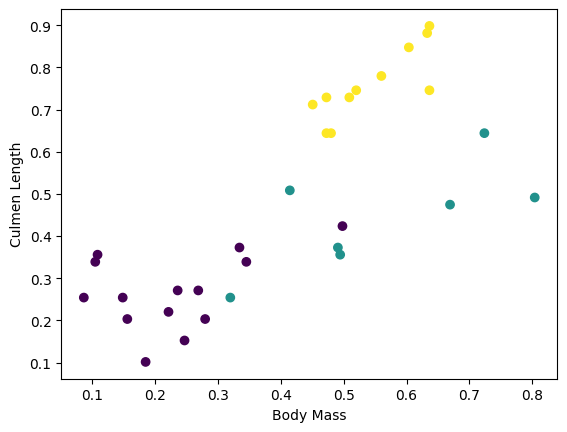

In [79]:
plt.scatter(features[:,0],
            features[:,2],
            c=labels,
            cmap='viridis')

plt.xlabel("Body Mass")
plt.ylabel("Culmen Length")
plt.show()


In [80]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])


In [81]:
predictions = model(features)
predictions[:5]


<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-0.474,  0.176, -0.174],
       [-0.461,  0.214, -0.08 ],
       [-0.663,  0.232, -0.248],
       [-0.399,  0.157, -0.138],
       [-0.489,  0.241, -0.13 ]], dtype=float32)>

In [82]:
tf.nn.softmax(predictions[:5])


<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.234, 0.449, 0.316],
       [0.226, 0.444, 0.331],
       [0.202, 0.493, 0.305],
       [0.247, 0.432, 0.321],
       [0.222, 0.46 , 0.318]], dtype=float32)>

In [83]:
print("Prediction: {}".format(tf.math.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))


Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [0 2 1 0 0 1 1 1 0 1 1 0 0 0 0 2 2 2 0 0 0 0 2 2 1 2 0 2 2 2 2 0]


In [84]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [85]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))


Loss test: 1.169450283050537


In [86]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)


In [87]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)


In [88]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))


Step: 0, Initial Loss: 1.169450283050537
Step: 1,         Loss: 1.1654927730560303


In [89]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in ds_train_batch:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


Epoch 000: Loss: 1.168, Accuracy: 19.476%
Epoch 050: Loss: 0.671, Accuracy: 80.524%
Epoch 100: Loss: 0.406, Accuracy: 80.524%
Epoch 150: Loss: 0.273, Accuracy: 94.007%
Epoch 200: Loss: 0.170, Accuracy: 97.378%


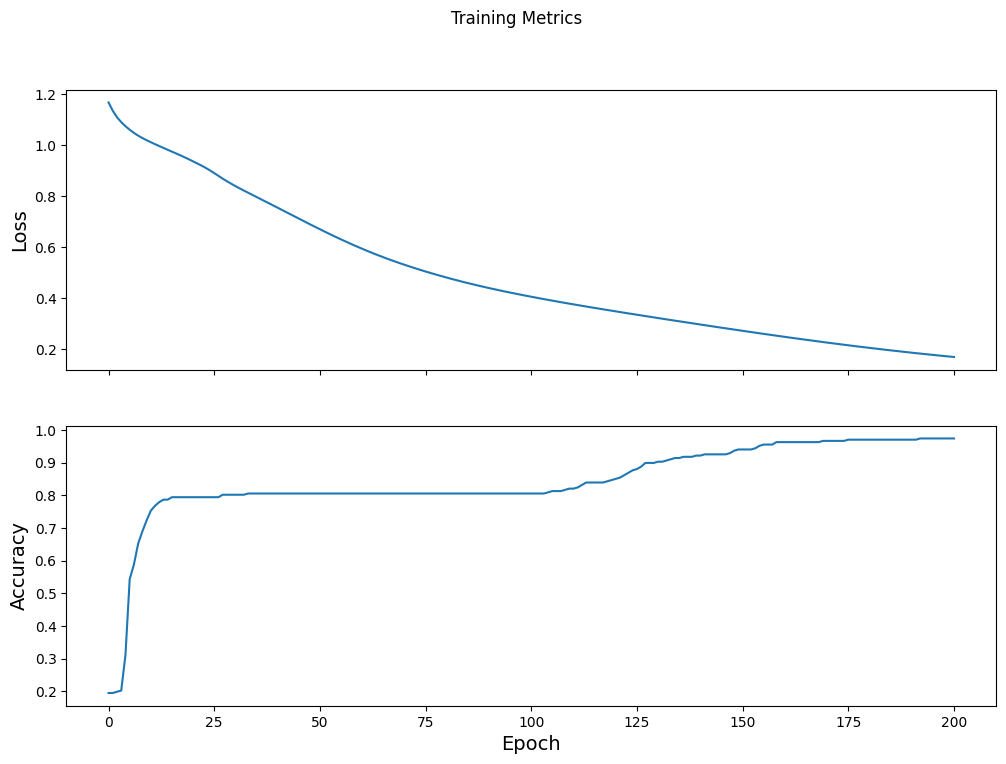

In [90]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()


In [91]:
test_accuracy = tf.keras.metrics.Accuracy()
ds_test_batch = ds_test.batch(10)

for (x, y) in ds_test_batch:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.math.argmax(logits, axis=1, output_type=tf.int64)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))


Test set accuracy: 97.015%


In [93]:
tf.stack([y,prediction],axis=1)


<tf.Tensor: shape=(7, 2), dtype=int64, numpy=
array([[1, 1],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [0, 0]], dtype=int64)>

In [94]:
predict_dataset = tf.convert_to_tensor([
    [0.3, 0.8, 0.4, 0.5,],
    [0.4, 0.1, 0.8, 0.5,],
    [0.7, 0.9, 0.8, 0.4]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
  class_idx = tf.math.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))


Example 0 prediction: Adélie (87.5%)
Example 1 prediction: Gentoo (99.2%)
Example 2 prediction: Chinstrap (71.7%)
